## Creating a graph from text data
Looking at the neighbours of a selected word

### Loading the text data

In [1]:
import pandas as pd
import itertools

In [2]:
graph_data_path = './Data/graph/'
pickle_data_path = './Data/pickle/'
series_name = 'marseille'
pickle_file = pickle_data_path+series_name+'_texts'+'.pkl'
vocab_file = pickle_data_path+series_name+'_vocab_bow'+'.pkl'
tfidf_file = pickle_data_path+series_name+'_vocab_tfidf'+'.pkl'

In [3]:
text_data = pd.read_pickle(pickle_file)
vocab_data = pd.read_pickle(vocab_file)
tfidf_data = pd.read_pickle(tfidf_file)

In [4]:
# create the set of most used words
#nb_words = 200
#word_set = set(tfidf_data.words[0:nb_words])

###  Selecting documents with particular keywords

In [5]:
# find the words that follow the keyword candidat_word
candidat_word = "liberté"
selected_Keywords = set(candidat_word.split())
data_subset = []
neighbour_list = []
for text in text_data.filtered_text:
    wordlist = str(text).split()
    if len(set(wordlist)&selected_Keywords)>=(len(selected_Keywords)):
        data_subset.append(text)
        word_ind = wordlist.index(candidat_word)
        if (word_ind+1<len(wordlist)):
            neighbour_list.append(wordlist[word_ind+1])

In [6]:
from collections import Counter

In [7]:
N_uniquedic = Counter(neighbour_list)
N_words = {k:v for (k,v) in N_uniquedic.items() if v > 0}
Ndf = pd.DataFrame(list(N_words.items()), columns=['word','nb_occur'])
Ndf = Ndf.sort_values('nb_occur',ascending=False)
Ndf = Ndf.reset_index(drop=True)

In [8]:
Ndf

,word,nb_occur
0,égalité,6
1,expression,5
2,totale,5
3,créative,5
4,Lorsque,4
5,fuir,4
6,faux,4
7,offerte,3
8,nouvelle,3
9,accès,3


## Computing the hirarchical structure 

In [149]:
def find_neighbours(word,df_texts,direction='forward'):
    # find the words that follow (direction='forward') or precede (direction='backward')
    # the keyword 'word' in the texts 'texts'
    # return 
    # * the list of keywords with their occurence in a pandas dataframe
    # * the list of texts where the word has been found
    # Example:
    #         word_list,texts_list = find_neighbours(word,texts,direction='forward')
    neighbour_list = []
    list_texts_subset = []
    #print(word)
    for index,row in df_texts.iterrows():
        #print(row)
        text = row.filtered_text
        if (not pd.isnull(text)):
            text = text.lower()
            wordlist = str(text).split()
            if direction=='forward':
                pass
            elif direction=='backward':
                wordlist.reverse()
            else :
                raise NameError('Unknown direction. Only \'forward\' or \'backward\' are allowed.')
            if len(set(wordlist)&set([word]))>0:
                word_ind = wordlist.index(word)
                list_texts_subset.append(index)
                if (word_ind+1<len(wordlist)):
                    neighbour_list.append(wordlist[word_ind+1])
    df_texts_subset =df_texts.loc[list_texts_subset]
    N_uniquedic = Counter(neighbour_list)
    # optionally: filter te dic for removing the lowest values
    N_words = {k:v for (k,v) in N_uniquedic.items() if v > 0}
    Ndf = pd.DataFrame(list(N_words.items()), columns=['word','nb_occur'])
    Ndf = Ndf.sort_values('nb_occur',ascending=False)
    Ndf = Ndf.reset_index(drop=True)
    return Ndf,df_texts_subset

In [150]:
def top_neighbours(word,df_texts,direction,top_n=10):
    Ndf,df_texts_subset = find_neighbours(word,df_texts,direction=direction)
    return Ndf.head(top_n),df_texts_subset

In [151]:
def graph_neighbours(G,parent,word,neighbour_data,layer_id):
    parent_node = word+parent+str(layer_id-1)
    total_occur = neighbour_data.nb_occur.sum()
    for idx,node_row in neighbour_data.iterrows():
        G.add_node(node_row.word+word+str(layer_id),name=node_row.word, occur=node_row.nb_occur)
        G.add_edge(parent_node,node_row.word+word+str(layer_id),weight=node_row.nb_occur*1.0/total_occur)
    return parent_node

In [152]:
def expand_neighbours(parent,word,df_texts,layer_id,layer_max=4,top_n=10,direction='forward'):
    if layer_id >= layer_max:
        return []
    neighbour_data,df_texts_subset = top_neighbours(word,df_texts,direction=direction,top_n=top_n)
    graph_neighbours(G,parent,word,neighbour_data,layer_id)
    layer_id+=1
    parent_node = word
    neighbour_list = list(neighbour_data.word)
    for nnode in neighbour_list:
        expand_neighbours(parent_node,nnode,df_texts_subset,layer_id,layer_max,top_n=top_n,direction=direction)

### Creating the graph

In [153]:
import networkx as nx
import matplotlib.pyplot as plt

In [155]:
G = nx.DiGraph()
# root word
candidat_word = "liberté"
layer_id=0
parent = ''
candidat_id = candidat_word+parent+str(layer_id)
# compute the number of occurences of the word:
print('Search for the candidat word')
word_list,df_texts_list = find_neighbours(candidat_word,text_data,direction='forward')#'forward')
nb_occur = len(df_texts_list)
print('number of texts: {}'.format(nb_occur))
G.add_node(candidat_id,name=candidat_word, occur=nb_occur)
# find children nodes
print('find children nodes')
expand_neighbours(parent,candidat_word,df_texts=df_texts_list,layer_id=1,layer_max=3,top_n=15,direction='backward')
#parent,level1 = expand_neighbours(parent,[candidat_word],text_data.filtered_text,top_n=10,layer_id=1)
#parent,level2 = expand_neighbours(parent,level1,text_data.filtered_text,top_n=2,layer_id=2)
#level3 = expand_neighbours(level2,text_data.filtered_text,top_n=10)
#level4 = expand_neighbours(level3,text_data.filtered_text,top_n=10)

Search for the candidat word
number of texts: 1050
find children nodes


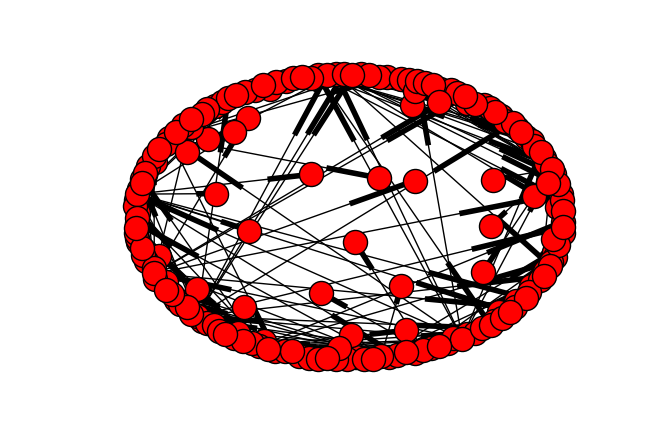

In [156]:
nx.draw_spring(G,)
plt.show()

In [157]:
G.size()

179

### Thresholding the edges

In [158]:
# Extracting the edge information
#sum_weight = 0
#n_edges = 0
#for u,v,a in G.edges(data=True):
#    sum_weight+=a['weight']
#    n_edges+=1
#average_weight = sum_weight*1.0/n_edges

In [159]:
# Node properties: degree and centrality
degreeDic = G.degree(weight='weight')
nx.set_node_attributes(G,'degree',degreeDic)
bcDic = nx.betweenness_centrality(G)
nx.set_node_attributes(G,'bCentrality',bcDic)

In [160]:
# Write the graph to a json file
from networkx.readwrite import json_graph
datag = json_graph.tree_data(G,root=candidat_id)
import json
s = json.dumps(datag)
#datag['links'] = [
#        {
#            'source': datag['nodes'][link['source']]['id'],
#            'target': datag['nodes'][link['target']]['id']
#        }
#        for link in datag['links']]
s = json.dumps(datag)
with open("./viz/treegraph"+series_name+".json", "w") as f:
    f.write(s)

### Open a web page for visualization

In [161]:
import webbrowser
url = 'http://localhost:8008/treegraphmarseille.html'
#webbrowser.open_new_tab(url)
webbrowser.open_new(url)

True

In [95]:
G.edges(data='weight')

[('usamiss1', 'risultatiusa2', 0.5),
 ('usamiss1', 'uberusa2', 0.18571428571428572),
 ('usamiss1', '2015usa2', 0.014285714285714285),
 ('usamiss1', 'affaireusa2', 0.29999999999999999),
 ('saintmiss1', 'antoinesaint2', 0.017857142857142856),
 ('saintmiss1', 'pierresaint2', 0.13690476190476192),
 ('saintmiss1', 'jeansaint2', 0.0059523809523809521),
 ('saintmiss1', 'menetsaint2', 0.16369047619047619),
 ('saintmiss1', 'exupérysaint2', 0.002976190476190476),
 ('saintmiss1', 'jamessaint2', 0.002976190476190476),
 ('saintmiss1', 'michelsaint2', 0.002976190476190476),
 ('saintmiss1', 'gillessaint2', 0.002976190476190476),
 ('saintmiss1', 'étiennesaint2', 0.002976190476190476),
 ('saintmiss1', 'barnabésaint2', 0.30654761904761907),
 ('saintmiss1', 'charlessaint2', 0.0059523809523809521),
 ('saintmiss1', 'rémysaint2', 0.33630952380952384),
 ('saintmiss1', 'cloudsaint2', 0.002976190476190476),
 ('saintmiss1', 'etiennesaint2', 0.002976190476190476),
 ('saintmiss1', 'vincentsaint2', 0.0059523809523

In [ ]:
clusterDic

In [131]:
neighbour_data1,df_texts_subset1 = top_neighbours('peau',df_texts_list,direction='forward',top_n=10)
print(neighbour_data1.head(1))
neighbour_data2,df_texts_subset2 = top_neighbours(neighbour_data1.head(1).word[0],df_texts_subset1,direction='forward',top_n=10)
print(neighbour_data2.head(1))
neighbour_data3,df_texts_subset3 = top_neighbours(neighbour_data2.head(1).word[0],df_texts_subset2,direction='forward',top_n=10)

#neighbour_data2,texts_subset2 = top_neighbours(neighbour_data.head(1).word[0],texts_subset1,direction='forward',top_n=10)


   word  nb_occur
0  yoga        73
   word  nb_occur
0  peut        73


In [134]:
df_texts_subset2.text.loc[11060]

'Marseille : garages "clandos" dans le viseur\nLe serial voleur de vélos démasqué aux Saintes-Maries\nMaison à 10 euros : 4 ans requis contre le créateur de la loterie\nLaïcité : malaise à la prison d\'Arles\nSorgues : hier, la justice a ordonné la démolition d\'une mosquée\nMarseille : la face cachée du voile islamique\nGrève nationale : manifs, blocages et bouchons, toutes nos infos en Provence\nLaïcité : malaise à la prison d\'Arles\nGrève nationale : manifs, transports en commun et écoles, ce qu\'il faut savoir en Provence\nLa région Paca se lance dans la course à la stratosphère\nMarseille : le tunnel Schloesing s\'effondre\nOléron: Alexia étranglée et poignardée pour avoir "repoussé les avances" du lycéen\nLa France et le Nigeria renforcent leur coopération militaire contre Boko Haram\nCorée du Nord: le Conseil de sécurité réuni à la demande des Etats-Unis\nLa Corée du Nord rate deux nouveaux tests de missile à moyenne portée, dit Séoul\nLoi travail: un policier grièvement blessé

In [46]:
neighbour_data1,texts_subset1 = top_neighbours('égalité',text_data.filtered_text,direction='forward',top_n=10)
print(neighbour_data1.head(1))
neighbour_data2,texts_subset2 = top_neighbours(neighbour_data1.head(1).word[0],texts_subset1,direction='forward',top_n=10)
print(neighbour_data2.head(1))
neighbour_data3,texts_subset3 = top_neighbours(neighbour_data2.head(1).word[0],texts_subset2,direction='forward',top_n=10)


       word  nb_occur
0  rivalité       891
         word  nb_occur
0  #marseille       834


In [45]:
texts_subset3

['marseille tarif salé fraude carburants sanglant braquage fourgon marseille jugé ans après douane 2015 année record marseille priorités stups armes cambriolages vols violence vaucluse volait dosettes nespresso revendait marseille aide psychologique cités bientôt réalité avignon douche itinérante personnes sans abri chantier vieux port marseille terrasses reviennent bouchons disparaissent provençaux lèvent coude aussi pied ciotat voilà premiers portiques sécurité collèges cgt oublier lepaon capter adhérents mort légende pop prince choque monde décès ans légendaire chanteur prince emissions polluantes psa perquisitionné jeudi méditerranée deux migrants racontent calvaire solar impulse reprend tour monde après 300 jours escale syrie kurdes créent armée protéger région fédérale marseille aménagement tronçon linea fait toujours débat premières projections présidentielle 2017 revue matinales christian estrosi veut poursuivre cgt diffamation affiche polémique marseille belkacem gaudin réunis